In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [5]:
data_five_minute = pd.read_excel("BRENT VOL.xlsx", sheet_name = "5M")
data_five_minute = data_five_minute.iloc[2:, 1:3]
data_five_minute.columns = ["Date", "Price"]
data_five_minute["Date"] = pd.to_datetime(data_five_minute["Date"])
data_five_minute['Price'] = pd.to_numeric(data_five_minute['Price'], errors='coerce')
data_five_minute.set_index("Date", inplace = True)

train_size_five = int(len(data_five_minute) * 0.70)
validation_size_five = int(len(data_five_minute) * 0.15)

train_data_five = data_five_minute[:train_size_five]
validation_data_five = data_five_minute[train_size_five:train_size_five + validation_size_five]
test_data_five = data_five_minute[train_size_five + validation_size_five:]

scaler = MinMaxScaler()
scaler_five = scaler.fit(train_data_five[["Price"]])
training_scaled_five = scaler_five.transform(train_data_five[["Price"]])
validation_scaled_five = scaler.transform(validation_data_five[["Price"]])
test_scaled_five = scaler.transform(test_data_five[["Price"]])

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        label = data[i + sequence_length]
        X.append(sequence)
        y.append(label)
    return np.array(X), np.array(y)

base_sequence_length = 20 # Here we set the sequence length to whatever we want, depending on what we have at hand

X_train_five , y_train_five = create_sequences(training_scaled_five, base_sequence_length)
X_val_five , y_val_five = create_sequences(validation_scaled_five, base_sequence_length)
X_test_five , y_test_five = create_sequences(test_scaled_five, base_sequence_length)

In [4]:
def fit_model(model, epochs=100, batch_size=32):
    model_history = model.fit(
    X_train_five, y_train_five,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_five, y_val_five),
    verbose=1,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )
    return model_history

In [5]:
def evaluate_model_performance(model, X_test=X_test_five, y_test=y_test_five, initial_capital=10000000):

    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    trades = []
    for i in range(len(predicted_prices) - 1):
        if predicted_prices[i + 1] > predicted_prices[i]:
            trades.append('buy')
        else:
            trades.append('sell')

    capital = initial_capital
    positions = 0 
    portfolio_value = [initial_capital] 
    returns = []
    gains = []

    for i, trade in enumerate(trades):
        current_price_scaled = X_test[i, -1, 0].reshape(-1, 1)
        current_price = scaler.inverse_transform(current_price_scaled)
        current_price = current_price[0, 0]

        if trade == 'buy' and capital >= current_price:
            q = capital // current_price
            if q > 0:
                capital -= q * current_price
                positions += q

        elif trade == 'sell' and positions > 0:
            capital += positions * current_price
            gains.append(positions * current_price - initial_capital)
            positions = 0

        portfolio_value.append(capital + positions * current_price)

        if i > 0:
            step_return = (portfolio_value[-1] - portfolio_value[-2]) / portfolio_value[-2]
            returns.append(step_return)

    cumulative_returns = np.cumprod(np.array(returns) + 1) - 1
    final_capital = capital + positions * current_price
    total_return = (final_capital - initial_capital) / initial_capital

    peak = np.maximum.accumulate(portfolio_value)
    drawdown = (peak - portfolio_value) / peak
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    print(f"The final portfolio value is: {final_capital}")
    print(f"The total return is: {total_return}")
    print(f"The maximum drawdown is: {np.max(drawdown)}")
    
    actual_prices = scaler.inverse_transform(X_test[:, -1, 0].reshape(-1, 1))
    axes[0, 0].plot(actual_prices, label='Actual prices')
    axes[0, 0].plot(predicted_prices, label='Predicted prices')
    axes[0, 0].legend()
    axes[0, 0].set_title('Actual vs Predicted Prices')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Price')

    axes[0, 1].plot(cumulative_returns, label='Cumulative Returns')
    axes[0, 1].legend()
    axes[0, 1].set_title('Cumulative Returns')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Cumulative Return')

    spread = actual_prices - predicted_prices
    axes[1, 0].hist(spread, label='Spread', bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[1, 0].legend()
    axes[1, 0].set_title('Spread between Actual and Predicted Prices')
    axes[1, 0].set_xlabel('Spread')
    axes[1, 0].set_ylabel('Frequency')

    axes[1, 1].plot(returns, label='Returns')
    axes[1, 1].legend()
    axes[1, 1].set_title('Returns')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Return')

    axes[2, 0].plot(drawdown, label='Drawdown', color='orange')
    axes[2, 0].legend()
    axes[2, 0].set_title('Drawdown')
    axes[2, 0].set_xlabel('Time')
    axes[2, 0].set_ylabel('Drawdown')

    sns.histplot(returns, kde=True, bins=50, color='blue', ax=axes[2, 1])
    axes[2, 1].set_title('Distribution of Returns')
    axes[2, 1].set_xlabel('Returns')
    axes[2, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [6]:
def plot_loss_history(model_history):

    plt.plot(model_history.history['loss'], label='Training Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_loss_history_kfold(history_list, title='Training and Validation Loss Across Folds'):
    plt.figure(figsize=(12, 6))
    for i, history in enumerate(history_list):
        plt.plot(history.history['loss'], label=f'Training Loss Fold {i+1}')
        plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i+1}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

X_combined = np.concatenate((X_train_five, X_val_five), axis=0)
y_combined = np.concatenate((y_train_five, y_val_five), axis=0)

120/120 [==============================] - 1s 7ms/step
The final portfolio value is: 25438102.20000001
The total return is: 1.543810220000001
The maximum drawdown is: 0.00011450801081013056


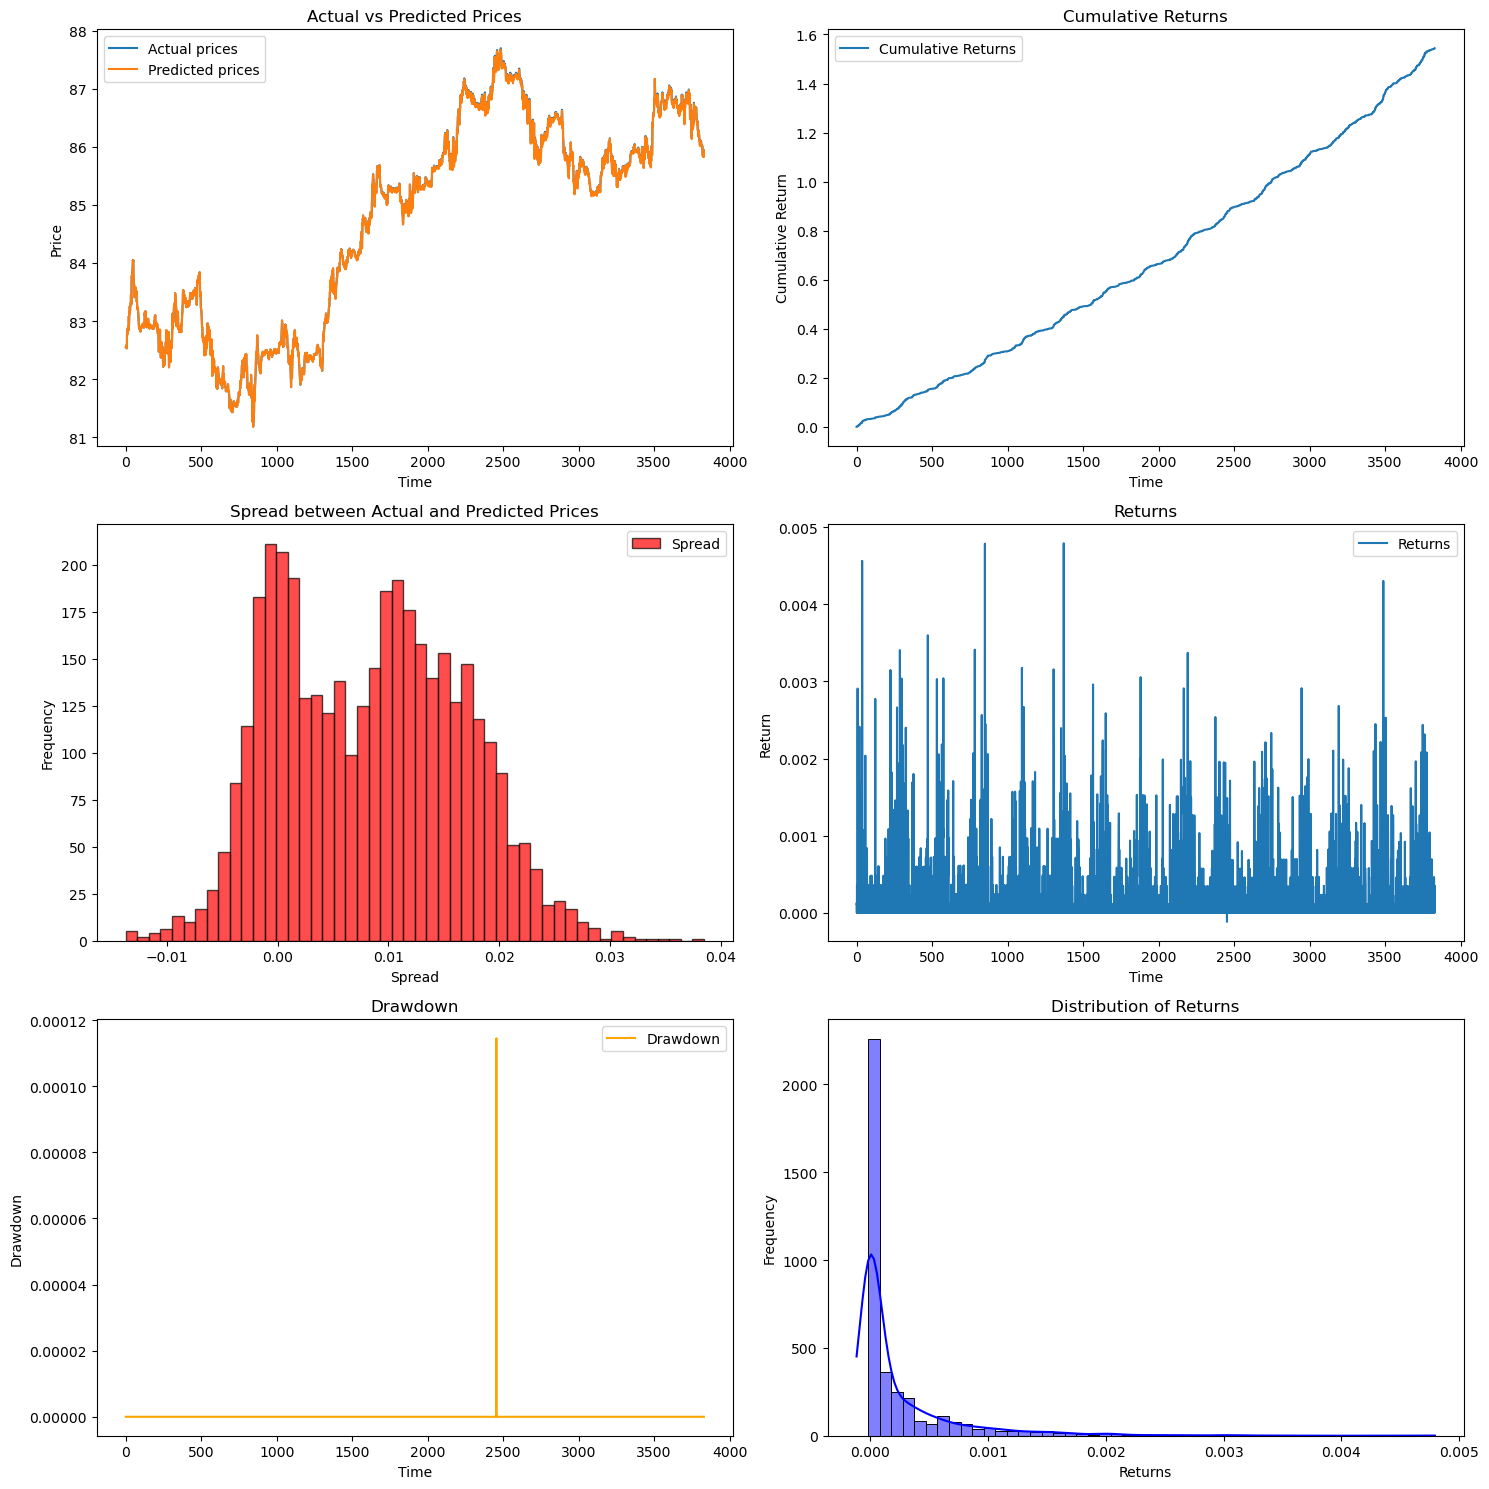

In [18]:
# We import the model that was saved in our building code
final_version_model = keras.models.load_model("GRU K-Fold Model")

evaluate_model_performance(final_version_model)
